In [1]:
#Imports
import sys
import numpy as np
from ast import literal_eval
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from collections import Counter

from sklearn.linear_model import LinearRegression

from model_inputs import split_on_h_group
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

In [2]:
#FUNCTIONS
def count_aa(encoding):
    '''Count differnt amino acid occurence in encoding
    '''
    counts = Counter(encoding)

    aa_feature = []
    for i in range(0,22):
        if i in counts.keys():
            aa_feature.append(counts[i])
        else:
            aa_feature.append(0)

    return aa_feature


def create_features(df):
    '''Get features
    '''
    #Get MLAAdist
    evdist = np.asarray(df['MLAAdist_x'])

    #Get encodings
    enc1 = []
    enc2 = []
    [enc1.append(literal_eval(x)) for x in df['enc1']]
    [enc2.append(literal_eval(x)) for x in df['enc2']]
    #Get lengths
    l1 = np.asarray(df['l1'])
    l2 = np.asarray(df['l2'])
    aln_len = np.asarray(df['aln_len'])
    #Get C.A.T.H
    C = list(df['C._x'])
    A = list(df['C.A._x'])
    H = list(df['H_group_x'])
    #Save features
    enc_feature = []


    for i in range(0, len(enc1)):
        enc_feature.append(count_aa(enc1[i]))
        enc_feature[i].extend(count_aa(enc2[i]))
        enc_feature[i].append(l1[i])
        enc_feature[i].append(l2[i])
        enc_feature[i].append(aln_len[i])
        enc_feature[i].append(evdist[i])
        enc_feature[i].append(float(C[i]))
        #enc_feature[i].append(float(A[i])) HAVE to assign each A and H an int
        #enc_feature[i].append(float(H[i]))


    #Get RMSDs
    rmsds = df['RMSD_x']
    bins = np.arange(0,4.5,0.1)
    #bins = np.arange(0.5,2.5,0.05)
    #bins = np.insert(bins,0, 0)
    #bins = np.append(bins, 4.5)
    #Bin the TMscore RMSDs
    binned_rmsds = np.digitize(rmsds, bins)

    #Data
    X = np.asarray(enc_feature)
    y = np.asarray(rmsds)
    y_binned = np.asarray(binned_rmsds) 
    return(X, y, y_binned)

In [4]:
complete_df.columns

Index(['uid1', 'uid2', 'MLAAdist_x', 'RMSD_x', 'TMscore', 'H_group_x', 'C._x',
       'C.A._x', 'MLAAdist_y', 'RMSD_y', 'TMscore_high', 'TMscore_low',
       'H_group_y', 'C._y', 'C.A._y', 'aln_len', 'identity', 'lse1', 'lse2',
       'encoding', 'deviation', 'l1', 'l2', 's1', 's2', 'e1', 'e2',
       'binned_deviation', 'enc1', 'enc2'],
      dtype='object')

In [3]:
#Read df
complete_df = pd.read_csv('/home/pbryant/evolution/visual/complete_df.csv')
#Split
train_groups, valid_groups, test_groups = split_on_h_group(complete_df, 0.8)
train_df = complete_df[complete_df['H_group_x'].isin(train_groups)]
valid_df = complete_df[complete_df['H_group_x'].isin(valid_groups)]
test_df = complete_df[complete_df['H_group_x'].isin(test_groups)]

In [5]:
X_train,y_train, y_train_binned = create_features(train_df)
X_valid,y_valid, y_valid_binned = create_features(valid_df)

In [6]:
#Compare with linear regression
reg = LinearRegression().fit(np.asarray(complete_df['MLAAdist_x']).reshape(-1,1), complete_df['RMSD_x'])
reg_predictions = reg.predict(np.asarray(complete_df['MLAAdist_x']).reshape(-1,1))
average_error = np.average(np.absolute(reg_predictions-complete_df['RMSD_x']))
print(average_error)

0.29990743494657146


In [12]:
#RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)


0.27216742202079447


In [6]:
#RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train, y_train)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid))
print(average_error)

#Binned fitting
# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)

0.2541651181907047
0.25581951923931395


In [7]:
importances = clf.feature_importances_
#importances = -np.log(importances)

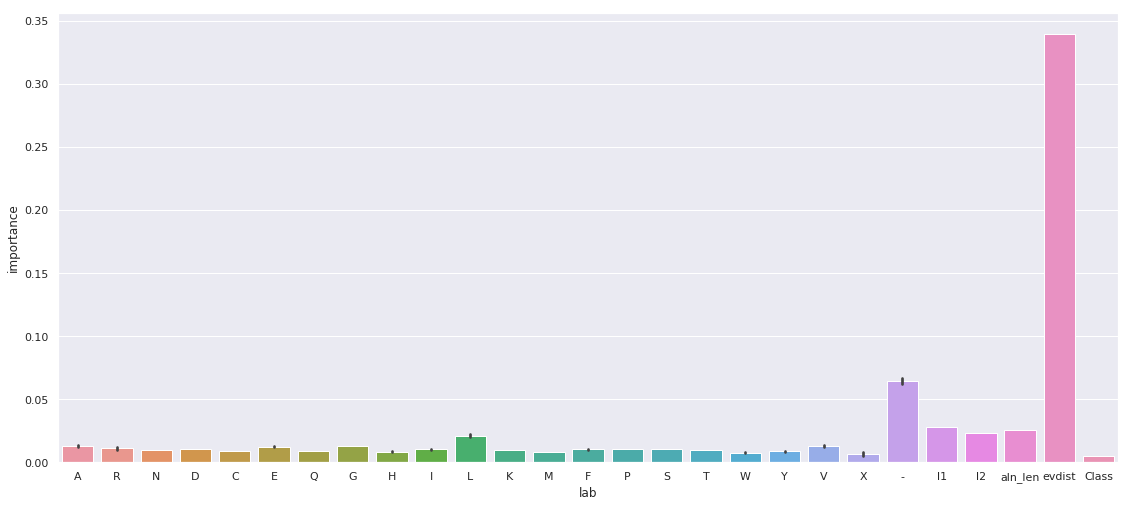

In [16]:
labels = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', '-', 'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', '-', 'l1', 'l2', 'aln_len', 'evdist', 'Class']
imp_df = pd.DataFrame({'lab':labels, 'importance':importances})
sns.barplot(x='lab', y='importance', data = imp_df)
sns.set(rc={'figure.figsize':(19,8.27)})
plt.show()

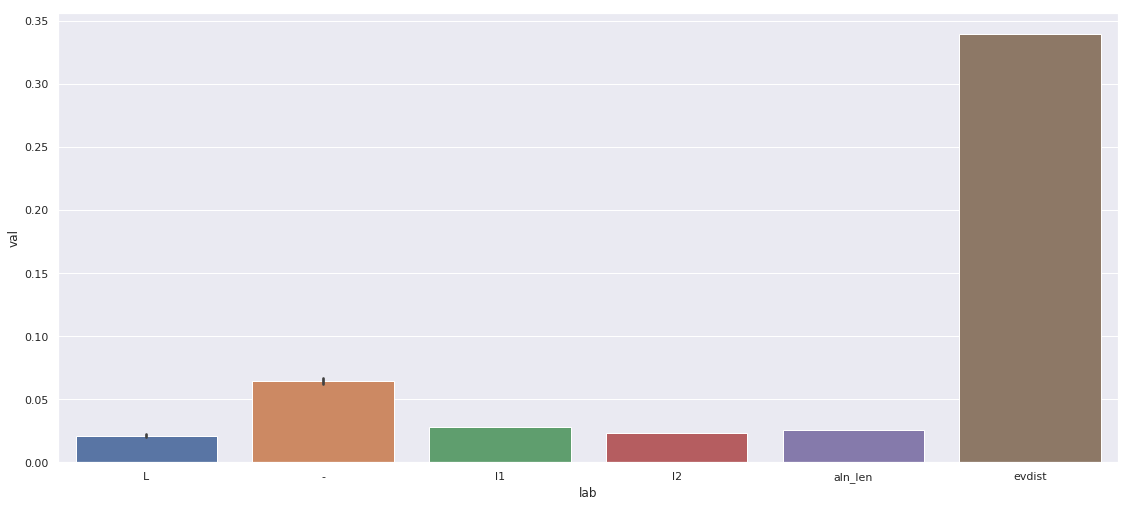

In [15]:
#It looks like Leucine, gaps, lengths of sequences and alignment as well as the evdist are the important features
importances_s = [importances[10],importances[21],importances[32],importances[43],importances[44],importances[45],importances[46],importances[47]]
labels = ['L', '-', 'L', '-', 'l1', 'l2', 'aln_len', 'evdist']
imp_df = pd.DataFrame({'lab':labels, 'val':importances_s})
sns.barplot(x='lab', y='val', data = imp_df)
sns.set(rc={'figure.figsize':(19,8.27)})
plt.show()

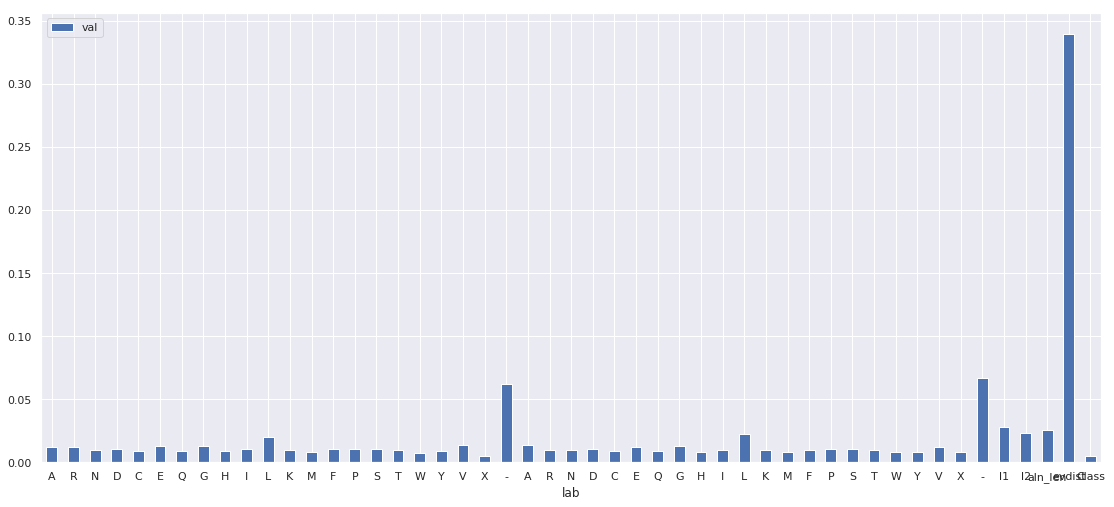

In [11]:
imp_df.plot.bar(x='lab', y='val',rot=0)

In [17]:
X_train_s = [X_train[:,10],X_train[21],X_train[32],X_train[43], X_train[44],X_train[45],X_train[46],X_train[47]]
X_valid_s = [X_valid[10],X_valid[21],X_valid[32],X_valid[43], X_valid[44],X_valid[45],X_valid[46],X_valid[47]]
#RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train_s, y_train)

#predict
clf_predictions = clf.predict(X_valid_s)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid))
print(average_error)

#Binned fitting
# Fit on training data
clf.fit(X_train_s, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid_s)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)

ValueError: Number of labels=29820 does not match number of samples=8